<a href="https://colab.research.google.com/github/NckYang/Baseball-Prediction-Project/blob/main/Mixed_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
--- 發現檔案 'statcast_data_2022_2025_full.parquet'，直接讀取 ---

##############################
### 階段一：準備訓練與驗證集 ###
##############################
將使用 2023-04-03 之前的所有數據 (共 733801 筆) 訓練通用模型。
將在 2023-04-03 之後的數據中進行驗證...

開始訓練【v34 宏觀策略模型】...
【v34 宏觀策略模型】訓練完成！

##############################
### 階段二：開始系統性驗證 ###
##############################
  -> 正在為驗證集準備特徵...
  -> 正在從驗證集中篩選關鍵情境...

### 系統性回測最終報告 (v34 宏觀模型) ###

--- 驗證情境: 3B1S ---
  -> 平均預測上壘機率: 0.3337 (33.37%)
  -> 該情境真實上壘機率: 0.3512 (35.12%)
  -> Brier 分數 (機率誤差): 0.2288 (越低越好，0.25為亂猜)
  -> Log Loss (對數損失): 0.6507 (越低越好，懲罰錯誤自信)
  -> 系統綜合準確率 (Accuracy at 0.5): 0.6483 (64.83%)
  -> 系統上壘類別 F1-Score (at 0.5): 0.0051

  詳細分類報告 (at 0.5):
              precision    recall  f1-score   support

  At-Bat Out     0.6489    0.9977    0.7864     30336
     On Base     0.3784    0.0026    0.0051     16418

    accuracy                         0.6483     46754
   macro avg     0.5136    0.5001    0.3957     46754
weighted avg     0.5

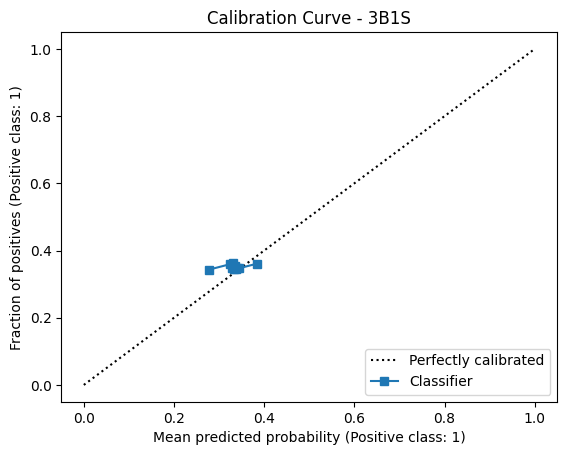


--- 驗證情境: 2S_AllB ---
  -> 平均預測上壘機率: 0.3122 (31.22%)
  -> 該情境真實上壘機率: 0.3205 (32.05%)
  -> Brier 分數 (機率誤差): 0.2184 (越低越好，0.25為亂猜)
  -> Log Loss (對數損失): 0.6288 (越低越好，懲罰錯誤自信)
  -> 系統綜合準確率 (Accuracy at 0.5): 0.6791 (67.91%)
  -> 系統上壘類別 F1-Score (at 0.5): 0.0028

  詳細分類報告 (at 0.5):
              precision    recall  f1-score   support

  At-Bat Out     0.6795    0.9987    0.8088    448683
     On Base     0.3436    0.0014    0.0028    211651

    accuracy                         0.6791    660334
   macro avg     0.5115    0.5001    0.4058    660334
weighted avg     0.5718    0.6791    0.5504    660334



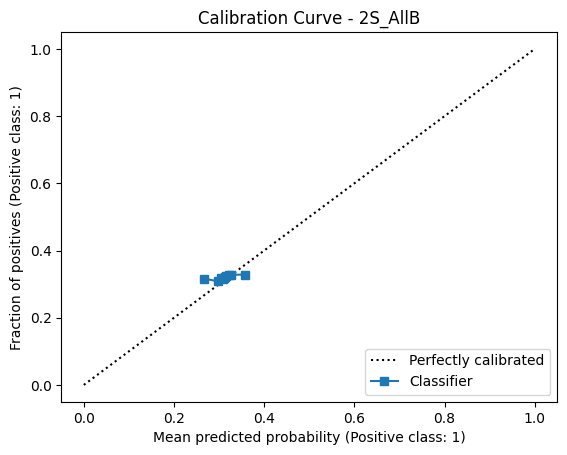

In [5]:
# -*- coding: utf-8 -*-
"""
Baseball Prediction v34.0 - Macro-Strategy Model

MLB Statcast 打者上壘預測模型 - 可分析多種對決情況
*** 版本 34.0 - 放棄物理模擬，回歸宏觀策略模型 ***
"""

# ========== 1. 安裝與匯入套件 ==========
!pip install pybaseball xgboost scikit-learn pandas numpy matplotlib seaborn imbalanced-learn fastparquet -q

import pandas as pd
import numpy as np
import os
import gc
from pybaseball import statcast, playerid_lookup
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, brier_score_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ========== 1.5 掛接 Google 雲端硬碟 ==========
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ========== 2. 輔助函式 ==========
ESSENTIAL_COLUMNS = [
    'game_date','batter','pitcher','events','strikes','balls','pitch_type', 'description',
    'outs_when_up','inning','home_team','p_throws','release_speed', 'release_spin_rate', 'game_pk',
    'plate_x','plate_z','pitch_number','at_bat_number',
    'on_1b','on_2b','on_3b','bat_score','fld_score',
    'stand', 'type'
]

def get_statcast_data(file_path):
    if os.path.exists(file_path):
        print(f"--- 發現檔案 '{os.path.basename(file_path)}'，直接讀取 ---")
        return pd.read_parquet(file_path)
    else:
        print(f"錯誤：找不到指定的數據檔案 '{file_path}'。")
        return None

def simplify_pitch_type(pitch):
    if pitch in ['FF', 'SI', 'FC', 'FT']: return 'FB_Fastball'
    elif pitch in ['SL', 'CU', 'ST', 'KC']: return 'BB_Breaking'
    elif pitch in ['CH', 'FS', 'FO']: return 'OS_Offspeed'
    return 'Other'

# ========== 3. v34 核心訓練與驗證模組 ==========

def train_at_bat_outcome_model_v34(df_train):
    """【v34 核心模型】訓練「打席最終結果」宏觀策略模型。"""
    print("\n" + "="*80); print(f"開始訓練【v34 宏觀策略模型】...")
    model_data = df_train.copy()

    # 1. 建立預測目標：at_bat_outcome
    at_bat_ending_events = ['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch', 'field_out', 'strikeout', 'grounded_into_double_play', 'force_out', 'sac_fly', 'sac_bunt', 'fielders_choice_out', 'field_error', 'double_play']
    model_data['is_at_bat_end'] = model_data['events'].isin(at_bat_ending_events)
    model_data['final_event'] = model_data.loc[model_data['is_at_bat_end']].groupby(['game_date', 'at_bat_number'])['events'].transform('last')
    model_data['final_event'] = model_data.groupby(['game_date', 'at_bat_number'])['final_event'].fillna(method='ffill').fillna(method='bfill')
    on_base_events = ['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch', 'field_error']
    model_data['at_bat_outcome'] = model_data['final_event'].isin(on_base_events).astype(int)

    # 2. 建立情境特徵 和 序列特徵
    CONTEXT_FEATURES = ['balls', 'strikes', 'outs_when_up', 'inning', 'on_1b', 'on_2b', 'on_3b', 'pitch_number', 'stand', 'p_throws']
    for col in ['balls', 'strikes', 'outs_when_up', 'inning']:
        model_data[col] = model_data[col].fillna(0).astype(int)
    for col in ['on_1b', 'on_2b', 'on_3b']:
        model_data[col] = model_data[col].fillna(0).astype(int)
    for col in ['stand', 'p_throws']:
        model_data[col] = model_data[col].fillna('Unknown')
    model_data = model_data.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])
    model_data['prev_pitch_type'] = model_data.groupby(['game_pk', 'at_bat_number'])['pitch_type'].shift(1).fillna('First_Pitch')
    key_outcomes = ['swinging_strike', 'foul', 'ball', 'called_strike', 'hit_into_play']
    model_data['pitch_outcome'] = model_data['description'].fillna('other').apply(lambda x: x if x in key_outcomes else 'other')
    model_data['prev_pitch_outcome'] = model_data.groupby(['game_pk', 'at_bat_number'])['pitch_outcome'].shift(1).fillna('First_Pitch')

    # 4. 最終數據準備
    CAT_FEATURES = ['stand', 'p_throws', 'prev_pitch_type', 'prev_pitch_outcome']
    NUM_FEATURES = ['balls', 'strikes', 'outs_when_up', 'inning', 'on_1b', 'on_2b', 'on_3b', 'pitch_number']

    model_data.dropna(subset=['at_bat_outcome'], inplace=True) # <-- 新的：只檢查 at_bat_outcome

    encoders = {}
    for col in CAT_FEATURES:
        le = LabelEncoder(); model_data[col] = le.fit_transform(model_data[col].astype(str)); encoders[col] = le

    ALL_FEATURES = NUM_FEATURES + CAT_FEATURES # <-- 新的：只使用原始特徵
    X = model_data[ALL_FEATURES]; y = model_data['at_bat_outcome']

    # 檢查數據是否足夠
    if len(X) < 100:
        print("警告: v34 宏觀模型數據量不足"); return None, None, None

    # 5. 訓練 v34 核心模型
    model_scale_pos_weight = (y == 0).sum() / (y.sum() if y.sum() > 0 else 1)
    model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', objective='binary:logistic', use_label_encoder=False, n_estimators=150, max_depth=5, learning_rate=0.05)
    model.fit(X, y)
    print("【v34 宏觀策略模型】訓練完成！"); return model, encoders, ALL_FEATURES

# ========== 4. v34 核心應用函式 ==========

def run_systematic_validation_v34(full_data, num_validation_samples=1000):
    """【v34 核心】執行系統性回測，並產出總體準確率報告。"""

    print("\n" + "#"*30); print("### 階段一：準備訓練與驗證集 ###"); print("#"*30)

    # 1. 篩選出所有相關對決
    is_3B1S = (full_data['balls'] == 3) & (full_data['strikes'] == 1)
    is_2S_AllB = (full_data['strikes'] == 2)
    full_data['events'] = full_data['events'].astype(str)
    full_data['description'] = full_data['description'].astype(str)
    # 我們不再移除 foul，因為 v34 模型預測的是「打席最終結果」，foul 只是過程

    target_pitches = full_data[is_3B1S | is_2S_AllB].copy()

    if len(target_pitches) < 100:
        print(f"錯誤：數據庫中只找到 {len(target_pitches)} 筆案例，數據不足以進行有意義的系統性回測。"); return

    # 2. 找到 25% 的時間分割點
    full_data['game_date'] = pd.to_datetime(full_data['game_date'])
    split_date = full_data['game_date'].quantile(0.25, interpolation='lower')

    df_train = full_data[full_data['game_date'] < split_date].copy()
    df_validation = full_data[full_data['game_date'] >= split_date].copy()

    print(f"將使用 {split_date.date()} 之前的所有數據 (共 {len(df_train)} 筆) 訓練通用模型。")
    print(f"將在 {split_date.date()} 之後的數據中進行驗證...")

    # 3. 訓練所有通用模型
    outcome_model, outcome_encoders, outcome_features = train_at_bat_outcome_model_v34(df_train)

    if outcome_model is None:
        print("\n錯誤：一個或多個通用模型訓練失敗，無法繼續驗證。"); return

    print("\n" + "#"*30); print("### 階段二：開始系統性驗證 ###"); print("#"*30)

    # 4. 準備驗證集 (df_validation)
    print("  -> 正在為驗證集準備特徵...")
    validation_data = df_validation.copy()

    # 4a. 建立預測目標 (真實答案)
    at_bat_ending_events = ['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch', 'field_out', 'strikeout', 'grounded_into_double_play', 'force_out', 'sac_fly', 'sac_bunt', 'fielders_choice_out', 'field_error', 'double_play']
    validation_data['is_at_bat_end'] = validation_data['events'].isin(at_bat_ending_events)
    validation_data['final_event'] = validation_data.loc[validation_data['is_at_bat_end']].groupby(['game_date', 'at_bat_number'])['events'].transform('last')
    validation_data['final_event'] = validation_data.groupby(['game_date', 'at_bat_number'])['final_event'].fillna(method='ffill').fillna(method='bfill')
    on_base_events = ['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch', 'field_error']
    validation_data['at_bat_outcome'] = validation_data['final_event'].isin(on_base_events).astype(int)

    # 4b. 建立情境與序列特徵
    for col in ['balls', 'strikes', 'outs_when_up', 'inning']:
        validation_data[col] = validation_data[col].fillna(0).astype(int)
    for col in ['on_1b', 'on_2b', 'on_3b']:
        validation_data[col] = validation_data[col].fillna(0).astype(int)
    validation_data = validation_data.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])
    validation_data['prev_pitch_type'] = validation_data.groupby(['game_pk', 'at_bat_number'])['pitch_type'].shift(1).fillna('First_Pitch')
    key_outcomes = ['swinging_strike', 'foul', 'ball', 'called_strike', 'hit_into_play']
    validation_data['pitch_outcome'] = validation_data['description'].fillna('other').apply(lambda x: x if x in key_outcomes else 'other')
    validation_data['prev_pitch_outcome'] = validation_data.groupby(['game_pk', 'at_bat_number'])['pitch_outcome'].shift(1).fillna('First_Pitch')

    # 4d. 準備最終的 X_test 和 y_test
    CAT_FEATURES = ['stand', 'p_throws', 'prev_pitch_type', 'prev_pitch_outcome']
    NUM_FEATURES = ['balls', 'strikes', 'outs_when_up', 'inning', 'on_1b', 'on_2b', 'on_3b', 'pitch_number']
    ALL_FEATURES = NUM_FEATURES + CAT_FEATURES

    for col in CAT_FEATURES:
        validation_data[col] = validation_data[col].fillna('Unknown')
        le = outcome_encoders[col]
        validation_data[col] = validation_data[col].map(lambda s: s if s in le.classes_ else 'Unknown')
        le_classes = le.classes_.tolist()
        if 'Unknown' not in le_classes: le.classes_ = np.append(le.classes_, 'Unknown')
        validation_data[col] = le.transform(validation_data[col])

    validation_data.dropna(subset=['at_bat_outcome'], inplace=True)

    X_test = validation_data.reindex(columns=outcome_features, fill_value=0)
    y_test = validation_data['at_bat_outcome']

    # 5. 篩選出您關心的情境
    print("  -> 正在從驗證集中篩選關鍵情境...")
    is_3B1S_val = (X_test['balls'] == 3) & (X_test['strikes'] == 1)
    is_2S_AllB_val = (X_test['strikes'] == 2)

    # 6. 產出最終總結報告
    print("\n" + "="*80); print("### 系統性回測最終報告 (v34 宏觀模型) ###"); print("="*80)

    for context_name, context_filter in [('3B1S', is_3B1S_val), ('2S_AllB', is_2S_AllB_val)]:
        print(f"\n--- 驗證情境: {context_name} ---")
        X_context = X_test[context_filter]
        y_context = y_test[context_filter]

        if len(y_context) == 0:
            print("無足夠數據可供評估。"); continue

        y_pred_proba = outcome_model.predict_proba(X_context)[:, 1] # 獲取上壘 (類別1) 的機率
        y_pred_class = (y_pred_proba >= 0.5).astype(int)

        loss = log_loss(y_context, y_pred_proba)

        # --- 評估機率準確性 ---
        avg_predicted_proba = np.mean(y_pred_proba)
        avg_actual_outcome = np.mean(y_context)
        brier = brier_score_loss(y_context, y_pred_proba)

        print(f"  -> 平均預測上壘機率: {avg_predicted_proba:.4f} ({avg_predicted_proba*100:.2f}%)")
        print(f"  -> 該情境真實上壘機率: {avg_actual_outcome:.4f} ({avg_actual_outcome*100:.2f}%)")
        print(f"  -> Brier 分數 (機率誤差): {brier:.4f} (越低越好，0.25為亂猜)")
        print(f"  -> Log Loss (對數損失): {loss:.4f} (越低越好，懲罰錯誤自信)")

        # --- 評估分類準確性 (使用 0.5 閾值) ---
        accuracy = accuracy_score(y_context, y_pred_class)
        f1 = f1_score(y_context, y_pred_class, pos_label=1, zero_division=0)

        print(f"  -> 系統綜合準確率 (Accuracy at 0.5): {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"  -> 系統上壘類別 F1-Score (at 0.5): {f1:.4f}")
        print("\n  詳細分類報告 (at 0.5):")
        print(classification_report(y_context, y_pred_class, target_names=['At-Bat Out', 'On Base'], zero_division=0, digits=4))

        # --- 繪製校準曲線 ---
        fig, ax = plt.subplots()
        CalibrationDisplay.from_predictions(y_context, y_pred_proba, n_bins=10, ax=ax, strategy='quantile')
        ax.set_title(f"Calibration Curve - {context_name}")
        plt.show()

# ========== MAIN EXECUTION BLOCK ==========
if __name__ == "__main__":
    drive_folder_path = '/content/drive/MyDrive/MLB_Statcast_Data/'
    full_data_path = os.path.join(drive_folder_path, "statcast_data_2022_2025_full.parquet")
    full_data = get_statcast_data(full_data_path)
    if full_data is not None:
        run_systematic_validation_v34(full_data=full_data)